In [1]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os
from os import path
import io
!pip3 install soundfile
!pip3 install librosa
import soundfile as sf
import librosa.feature


In [2]:
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=8ff1f995e54768668695c7480285440e5243584ef98b2652993cdfad21e253fd
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [3]:
LABELS = ['indoor', 'outdoor', 'transportation']

time: 1.1 ms


In [4]:
FILEPATH = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features.csv'

time: 1.12 ms


Labels:


0.   Indoor
1.   Outdoor
2.   Transportation



In [5]:
def clear_csv(FILEPATH):
    if os.path.exists(FILEPATH):
        # clear the file
        f = open(FILEPATH, "w")
        f.truncate()
        f.close()

time: 2.22 ms


# Getting Features

1.   Centroid Mean
2.   Centroid STD
3.   Flatness Mean
4.   Flatness STD
5.   RMS



In [6]:
BASE_PATH = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/'
df = pd.DataFrame()
for i in range(1,17):
    filepath = BASE_PATH + 'FEATSALVARO/output-nomfcc' + str(i) +'.csv'
    print(filepath)
    new = pd.read_csv(filepath)
    df = pd.concat([df,new])

/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc1.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc2.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc3.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc4.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc5.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc6.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc7.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc8.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATS

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,2067.040860,314.869340,0.001209,0.000798,0.002049,0.000470,-596.583604,162.614480,-0.670808,21.993716,16.195587,11.842820,11.357465,9.448603,8.314201,6.413948,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor
1,2395.956778,837.186014,0.002879,0.004073,0.002581,0.000732,-561.432028,164.141569,-10.586786,11.820866,18.119139,23.761645,22.446430,15.891833,7.592193,8.502080,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor
2,2135.921705,951.448528,0.002354,0.006510,0.002719,0.000589,-562.937612,172.182573,-4.441985,12.757403,14.173953,15.298843,18.722191,10.421974,8.023156,6.573807,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor
3,3453.224033,2039.474046,0.009713,0.018070,0.002108,0.000442,-550.226488,139.243877,0.369526,16.225726,10.133525,45.845596,31.659723,15.694685,12.090169,11.095157,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor
4,2306.123043,400.195968,0.002110,0.001470,0.001713,0.000348,-591.877872,158.679170,-3.883430,22.450031,18.368381,26.561454,11.428342,10.014569,8.082940,7.796495,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor


time: 58.5 ms


Factorizar nomes das musicas

In [8]:
df['16'], unique = pd.factorize(df['16'])
df.head(), unique

(             0            1         2  ...         15  16      17
 0  2067.040860   314.869340  0.001209  ...   6.413948   0  indoor
 1  2395.956778   837.186014  0.002879  ...   8.502080   0  indoor
 2  2135.921705   951.448528  0.002354  ...   6.573807   0  indoor
 3  3453.224033  2039.474046  0.009713  ...  11.095157   0  indoor
 4  2306.123043   400.195968  0.002110  ...   7.796495   0  indoor
 
 [5 rows x 18 columns],
 Index(['/content/drive/My Drive/tavares/soundfiles/TAU-urban-acoustic-scenes-2020-3class-development/audio/airport-barcelona-0-0-a.wav',
        '/content/drive/My Drive/tavares/soundfiles/TAU-urban-acoustic-scenes-2020-3class-development/audio/airport-barcelona-0-1-a.wav',
        '/content/drive/My Drive/tavares/soundfiles/TAU-urban-acoustic-scenes-2020-3class-development/audio/airport-barcelona-0-10-a.wav',
        '/content/drive/My Drive/tavares/soundfiles/TAU-urban-acoustic-scenes-2020-3class-development/audio/airport-barcelona-0-11-a.wav',
        '/content/

time: 54.1 ms


Factor Labels

In [9]:
df['17'], unique = pd.factorize(df['17'])
unique

Index(['indoor', 'transportation', 'outdoor'], dtype='object')

time: 12.2 ms


In [10]:
df = df[df['17'] != 2]

time: 9.25 ms


In [11]:
df[df['17'] != 0].shape, df[df['17'] != 1].shape

((28800, 18), (43200, 18))

time: 11.6 ms


In [12]:
#df.sample(frac=0.1, random_state=1)

time: 668 µs


DF: Descrição

        features
*   0-9: MFCSS (media e std, respectivamente)
*   20: média centroide 
*   21: std centroide
*   22: media flatness
*   23: std flatness
*   24: rms

        outros
*   25: LABEL
*   26: Music_id






In [13]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pickle
from collections import Counter
from sklearn.decomposition import PCA
import seaborn as sns

time: 41.3 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Split no dataframe baseado em grupos do número da música

In [14]:
def split_by_music_id(df):
    coluna_ids_musica = len(df.columns) - 2
    train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, random_state = 42).split(df, groups=df.iloc[:,coluna_ids_musica].values))
    return [train_inds, test_inds]

time: 2.76 ms


Split no dataframe selecionado, em teste e treino

In [15]:
def split_train_test(df,train_inds, test_inds):
    X_train = (df.iloc[train_inds, 0:-2])
    X_test = (df.iloc[test_inds,0:-2])
    y_train = (df.iloc[train_inds,[-2,-1]]).values
    y_test = (df.iloc[test_inds,[-2,-1]]).values
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return [X_train, X_test, y_train, y_test]

time: 4.04 ms


In [16]:
def standardize(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train.values)
    X_train = scaler.transform(X_train.values)
    X_test = scaler.transform(X_test.values)
    return [X_train, X_test]

time: 89.4 ms


# Linear SVC Classifier

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report, plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.externals import joblib

time: 7.39 ms


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [18]:
def get_model_linearSVC(X_train,y_train, y_test, X_test):
    C = [0.001, 0.01, 0.1, 1, 10, 100]
    for c in C:
        LSVC = LinearSVC(C = c, dual=False)
        LSVC.fit(X_train,y_train)
        y_pred = LSVC.predict(X_test)
        
        print("C: ", c)
        print("LSVC Accuracy :", accuracy_score(y_test, y_pred))
    filename = BASE_PATH + 'linearsvc_no_esp.pkl'
    joblib.dump(LSVC, filename,compress=0)
    return LSVC, y_pred

time: 6.08 ms


Contagem das predições para cada música

In [19]:
def plot_cf(y_pred, y_test):
    print(classification_report(y_test, y_pred))

time: 1.22 ms


In [20]:
def contagem_predicoes(y_test, y_pred):
    counts = dict()
    for id in np.unique(y_test[:,0]):
        counts[id] = []
    print(counts)
    
    for t, p in zip(y_test, y_pred):
        #print(t,p)
        counts[t[0]].append(p)
    counter = [Counter(y) for x,y in counts.items()]
    print(len(counter))
    return counter

def acc_votacao(counter, y_test):
    #print(np.unique(y_test[1]))
    #print(counter, y_test)
    music_y_pred = [max(x, key=x.get) for x in counter]
    print(len(music_y_pred))
    #music_y_test = [[x,y] for x,y in y_test]
    #music_y_test = np.unique(music_y_test, axis=0)[:,0]
    music_y_test = np.unique(y_test, axis=0)[:,1]
    print(len(music_y_test))
    plot_cf(music_y_pred, music_y_test)
    return metrics.accuracy_score(music_y_test,music_y_pred)

time: 13.8 ms


In [21]:
def pca(X_test, y_test):
    pca = PCA(3)
    trans_pca = pca.fit_transform(X_test)
    trans_pca = pd.DataFrame(trans_pca)
    trans_pca['Labels'] = y_test[:,1]
    trans_pca["Labels"] = ["$%s$" % x for x in trans_pca["Labels"]]
    print(pca.explained_variance_)
    trans_pca.columns = ['PC1', 'PC2','PC3','Labels']
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=trans_pca['PC1'], y=trans_pca['PC2'], hue=trans_pca['Labels'])

time: 5.65 ms


In [25]:
def classify(df):
    train_inds, test_inds = split_by_music_id(df)
    X_train, X_test, y_train, y_test = split_train_test(df,train_inds, test_inds) 
    X_train, X_test = standardize(X_train, X_test)
    model, y_pred = get_model_linearSVC(X_train,y_train[:,1], y_test[:,1], X_test)
    contagens = contagem_predicoes(y_test, y_pred)
    final_accuracy = acc_votacao(contagens, y_test)
    pca(X_test, y_test)
    return final_accuracy

time: 3.61 ms


(57600, 16) (14400, 16) (57600, 2) (14400, 2)
C:  0.001
LSVC Accuracy : 0.87625
C:  0.01
LSVC Accuracy : 0.87625
C:  0.1
LSVC Accuracy : 0.8763194444444444
C:  1
LSVC Accuracy : 0.8761111111111111
C:  10
LSVC Accuracy : 0.8761111111111111
C:  100
LSVC Accuracy : 0.8761111111111111
{8: [], 14: [], 17: [], 19: [], 23: [], 31: [], 37: [], 41: [], 45: [], 50: [], 51: [], 57: [], 61: [], 65: [], 73: [], 79: [], 80: [], 84: [], 87: [], 88: [], 91: [], 93: [], 95: [], 96: [], 100: [], 101: [], 106: [], 131: [], 132: [], 156: [], 157: [], 167: [], 168: [], 169: [], 176: [], 177: [], 179: [], 185: [], 188: [], 196: [], 198: [], 199: [], 208: [], 210: [], 216: [], 217: [], 221: [], 228: [], 230: [], 231: [], 233: [], 239: [], 245: [], 247: [], 248: [], 251: [], 254: [], 259: [], 263: [], 265: [], 286: [], 290: [], 291: [], 296: [], 308: [], 318: [], 319: [], 321: [], 322: [], 323: [], 324: [], 325: [], 332: [], 333: [], 334: [], 339: [], 346: [], 347: [], 351: [], 371: [], 373: [], 376: [], 378:

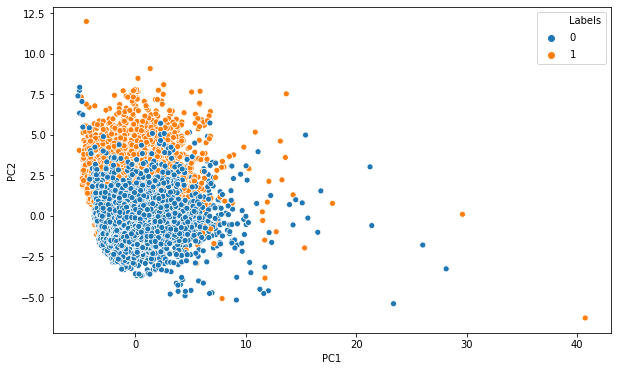

time: 3.23 s


In [26]:
acc = classify(df)
print(acc)

Tamanho do modelo em KB

In [24]:
(os.path.getsize(BASE_PATH + 'linearsvc_no_esp.pkl')/1024)

0.9326171875

time: 3.31 ms
